# NARR: Subsetting and OPeNDAP

## About the Dataset

This tutorial uses data from NOAA's [North American Regional Reanalysis](https://www.ncei.noaa.gov/products/weather-climate-models/north-american-regional) (NARR)

> The North American Regional Reanalysis (NARR) is a model produced by the National Centers for Environmental Prediction (NCEP) that generates reanalyzed data for temperature, wind, moisture, soil, and dozens of other parameters. The NARR model assimilates a large amount of observational data from a variety of sources to produce a long-term picture of weather over North America.

For this recipe, we will access the data via [OPeNDAP](https://earthdata.nasa.gov/collaborate/open-data-services-and-software/api/opendap), a widely-used API for remote access of environmental data over HTTP.
A key point is that, since we use using OPeNDAP, _there are no input files to download / cache_. We open the data directly from the remote server.

The data we will use are catalogged here (3D data on pressure levels): <https://psl.noaa.gov/thredds/catalog/Datasets/NARR/pressure/catalog.html>

Let's peek at one file. Xarray should automatically do the right thing with the OPeNDAP url. But just to be safe, we can pass the option, `engine='netcdf4'`, which is needed to open OPeNDAP links correctly. (We will need this again later when writing our recipe.)

In [1]:
import xarray as xr
url = "https://psl.noaa.gov/thredds/dodsC/Datasets/NARR/pressure/air.197901.nc"
ds = xr.open_dataset(url, engine='netcdf4')
ds

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:            (time: 248, level: 29, y: 277, x: 349)
Coordinates:
  * time               (time) datetime64[ns] 1979-01-01 ... 1979-01-31T21:00:00
  * level              (level) float32 1e+03 975.0 950.0 ... 150.0 125.0 100.0
  * y                  (y) float32 0.0 3.246e+04 ... 8.927e+06 8.96e+06
  * x                  (x) float32 0.0 3.246e+04 ... 1.126e+07 1.13e+07
    lat                (y, x) float32 ...
    lon                (y, x) float32 ...
Data variables:
    Lambert_Conformal  int32 ...
    air                (time, level, y, x) float32 ...
Attributes: (12/17)
    Conventions:                     CF-1.2
    centerlat:                       50.0
    centerlon:                       -107.0
    comments:                        
    institution:                     National Centers for Environmental Predi...
    latcorners:                      [ 1.000001  0.897945 46.3544   46.63433 ]
    ...                              ...
    history:                         created Fri Jan  8 02:35:07 MST 2016 by ...
    dataset_title:                   NCEP North American Regional Reanalysis ...
    references:                      https://www.esrl.noaa.gov/psd/data/gridd...
    source:                          http://www.emc.ncep.noaa.gov/mmb/rreanl/...
    References:                      
    DODS_EXTRA.Unlimited_Dimension:  time

This is just one file.
But it's a very big file (several GB)!
We will want to use the __subsetting__ capability of `XarrayZarrRecipe`. 
To figure out how to subset, let's examine the `_ChunkSizes` attribute.
This attribute part of the NetCDF4 files that the OPeNDAP server is serving.
We want to make sure our subsetting is compatible with the internal chunking of the files.

In [2]:
ds.air._ChunkSizes

array([  1,   1, 277, 349], dtype=int32)

This tells us that we can subset in the `time` or `level` dimensions, but problably should avoid subsetting in the `x` and `y` dimensions.

## Define File Pattern

We are now ready to define the `FilePattern` for the recipe. There is one file per month. So we start with a function like this:

In [3]:
def format_function(time):
    return f"https://psl.noaa.gov/thredds/dodsC/Datasets/NARR/pressure/air.{time}.nc"

To keep things short and simple for this tutorial, we will just use one file, and subset it into many chunks.
But we could easily add more months to build up the entire dataset.
Since each file is monthly, and the number of days per months varies, we cannot set `nitems_per_input` in the `ConcatDim`.

```{note}
It's important that we specify `is_opendap=True` when creating a FilePattern with OPeNDAP URLs.
OPeNDAP is actually an API, so there are no files to download. 
```

In [4]:
from pangeo_forge_recipes.patterns import FilePattern, ConcatDim, MergeDim
time_dim = ConcatDim("time", ["197901"])
pattern = FilePattern(format_function, time_dim, is_opendap=True)
pattern

<FilePattern {'time': 1}>

## Define the Recipe

This tutorial introduces a new option we have not seen before: `subset_inpus={"time": 30}`. This tells the `XarrayZarrRecipe` to break each input file into 30 distinct chunks along the `time` dimension. 

Some other points to consider when defining this recipe.
- Since the inputs are OPeNDAP, we want to use `is_opendap=True`.
- Since we have not specified `nitems_per_input` in the `FilePattern`, we need to explicitly set the target chunks.

In [5]:
from pangeo_forge_recipes.recipes import XarrayZarrRecipe
recipe = XarrayZarrRecipe(
    pattern, 
    subset_inputs={"time": 30},
    target_chunks={"time": 1},
)
recipe

XarrayZarrRecipe(file_pattern=<FilePattern {'time': 1}>, storage_config=StorageConfig(target=FSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x17b844b50>, root_path='/var/folders/n8/63q49ms55wxcj_gfbtykwp5r0000gn/T/tmpn896gtow/2JY3Gggp'), cache=CacheFSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x17b844b50>, root_path='/var/folders/n8/63q49ms55wxcj_gfbtykwp5r0000gn/T/tmpn896gtow/HqBtIUyg'), metadata=MetadataTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x17b844b50>, root_path='/var/folders/n8/63q49ms55wxcj_gfbtykwp5r0000gn/T/tmpn896gtow/CP6OARge')), inputs_per_chunk=1, target_chunks={'time': 1}, cache_inputs=False, copy_input_to_local_file=False, consolidate_zarr=True, consolidate_dimension_coordinates=True, xarray_open_kwargs={'engine': 'netcdf4'}, xarray_concat_kwargs={}, delete_input_encoding=True, process_input=None, process_chunk=None, lock_timeout=None, subset_inputs={'time': 30}, open_input_with_fsspec_referen

## Run the Recipe

In [6]:
# logging will display some interesting information about our recipe during execution
from pangeo_forge_recipes.recipes import setup_logging

setup_logging()

Here we just use the simple python function executor.

In [7]:
recipe.to_function()()

[02/17/22 08:56:16] INFO     Opening input with Xarray                     ]8;id=132229;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=997501;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Caching metadata for input                    ]8;id=235729;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=676626;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

/Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py:111: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  return xr.open_zarr(target.get_mapper())


                    INFO     Creating a new dataset in target              ]8;id=574080;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=9691;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#451\451]8;;\

                    INFO     Opening inputs for chunk                      ]8;id=378898;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=557449;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=0,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=603919;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=569869;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Subsetting input according to time-0          ]8;id=973847;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=285302;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=200460;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=154794;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=0,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})'                                                          

[02/17/22 08:56:17] INFO     Storing dataset in /var/folders/n8/63q49ms55w ]8;id=215259;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=227351;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#493\493]8;;\
                             xcj_gfbtykwp5r0000gn/T/tmpn896gtow/2JY3Gggp                     

                    INFO     Expanding target concat dim 'time' to size    ]8;id=637704;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=954275;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#507\507]8;;\
                             248                                                             

                    INFO     Opening inputs for chunk                      ]8;id=242065;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=55822;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=0,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=434474;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=863849;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[02/17/22 08:56:18] INFO     Subsetting input according to time-0          ]8;id=368985;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=732447;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=632018;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=450449;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=0,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=541797;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=934980;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=0,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(0, 8, None),)                       

[02/17/22 08:57:07] INFO     Storing variable air chunk                    ]8;id=671087;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=872899;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=0,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(0, 8, None),                        
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=53556;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=102897;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=1,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=360657;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=907838;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[02/17/22 08:57:08] INFO     Subsetting input according to time-1          ]8;id=625583;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=574439;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=592248;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=283017;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=1,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=581177;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=873906;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=1,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(8, 16, None),)                      

[02/17/22 08:58:19] INFO     Storing variable air chunk                    ]8;id=859559;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=657507;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=1,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(8, 16, None),                       
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=110769;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=577115;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=2,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=51180;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=818504;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Subsetting input according to time-2          ]8;id=154633;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=30721;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=609536;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=888912;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=2,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=658631;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=822458;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=2,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(16, 24, None),)                     

[02/17/22 08:58:50] INFO     Storing variable air chunk                    ]8;id=415606;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=737174;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=2,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(16, 24, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=779651;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=911897;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=3,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=131300;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=378557;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[02/17/22 08:58:51] INFO     Subsetting input according to time-3          ]8;id=186957;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=405532;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=72659;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=385638;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=3,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=96704;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=111751;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=3,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(24, 32, None),)                     

[02/17/22 08:59:21] INFO     Storing variable air chunk                    ]8;id=366175;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=247822;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=3,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(24, 32, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=510002;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=243656;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=4,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=244574;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=244321;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[02/17/22 08:59:22] INFO     Subsetting input according to time-4          ]8;id=937445;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=428513;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=662734;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=874340;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=4,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=172289;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=634872;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=4,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(32, 40, None),)                     

[02/17/22 09:00:01] INFO     Storing variable air chunk                    ]8;id=351669;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=508679;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=4,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(32, 40, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=796737;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=368484;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=5,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=205224;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=713022;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[02/17/22 09:00:02] INFO     Subsetting input according to time-5          ]8;id=166450;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=963814;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=835428;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=246791;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=5,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=461772;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=187954;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=5,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(40, 48, None),)                     

[02/17/22 09:00:46] INFO     Storing variable air chunk                    ]8;id=70198;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=444697;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=5,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(40, 48, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=227771;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=293184;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=6,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=459508;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=182325;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[02/17/22 09:00:47] INFO     Subsetting input according to time-6          ]8;id=501718;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=79641;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=150375;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=712722;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=6,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

[02/17/22 09:00:48] INFO     Storing variable time chunk                   ]8;id=719124;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=414055;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=6,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(48, 56, None),)                     

[02/17/22 09:02:11] INFO     Storing variable air chunk                    ]8;id=59405;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=961267;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=6,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(48, 56, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=652316;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=364003;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=7,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=720643;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=26085;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[02/17/22 09:02:13] INFO     Subsetting input according to time-7          ]8;id=101732;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=93952;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=333097;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=447111;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=7,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=961459;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=962263;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=7,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(56, 64, None),)                     

[02/17/22 09:03:52] INFO     Storing variable air chunk                    ]8;id=252728;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=563563;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=7,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(56, 64, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=736025;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=338701;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=8,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=772037;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=645037;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Subsetting input according to time-8          ]8;id=407460;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=972282;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=419010;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=695677;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=8,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=52150;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=648971;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=8,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(64, 72, None),)                     

[02/17/22 09:04:44] INFO     Storing variable air chunk                    ]8;id=866740;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=894765;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=8,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(64, 72, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=164127;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=880921;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=9,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=141491;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=177914;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[02/17/22 09:04:45] INFO     Subsetting input according to time-9          ]8;id=613348;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=796415;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=251437;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=380383;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=9,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=252974;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=880870;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=9,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(72, 80, None),)                     

[02/17/22 09:05:16] INFO     Storing variable air chunk                    ]8;id=686074;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=84135;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=9,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(72, 80, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=31681;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=400662;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=10,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=612003;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=869798;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Subsetting input according to time-10         ]8;id=787185;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=932991;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=553414;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=617415;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=10,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=960773;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=735331;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=10,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(80, 88, None),)                     

[02/17/22 09:06:07] INFO     Storing variable air chunk                    ]8;id=927886;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=385380;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=10,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(80, 88, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=979556;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=784756;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=11,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=631596;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=559423;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[02/17/22 09:06:08] INFO     Subsetting input according to time-11         ]8;id=445582;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=737720;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=831178;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=783940;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=11,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=318020;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=136652;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=11,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(88, 96, None),)                     

[02/17/22 09:06:38] INFO     Storing variable air chunk                    ]8;id=425546;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=740511;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=11,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(88, 96, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=940975;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=76124;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=12,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=755562;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=693808;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[02/17/22 09:06:39] INFO     Subsetting input according to time-12         ]8;id=939463;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=295005;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=434393;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=990516;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=12,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=430080;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=397171;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=12,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(96, 104, None),)                    

[02/17/22 09:07:07] INFO     Storing variable air chunk                    ]8;id=814166;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=965583;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=12,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(96, 104, None),                     
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=145496;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=243250;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=13,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=164937;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=894680;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[02/17/22 09:07:08] INFO     Subsetting input according to time-13         ]8;id=602595;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=225786;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=537020;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=520539;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=13,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=789611;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=220431;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=13,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(104, 112, None),)                   

[02/17/22 09:08:01] INFO     Storing variable air chunk                    ]8;id=878307;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=203365;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=13,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(104, 112, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=717076;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=94238;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=14,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=298484;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=810084;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[02/17/22 09:08:02] INFO     Subsetting input according to time-14         ]8;id=747406;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=901906;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=134543;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=555530;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=14,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=126053;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=940309;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=14,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(112, 120, None),)                   

[02/17/22 09:08:45] INFO     Storing variable air chunk                    ]8;id=561832;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=807686;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=14,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(112, 120, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=597342;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=422054;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=15,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=757267;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=180616;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[02/17/22 09:08:46] INFO     Subsetting input according to time-15         ]8;id=941865;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=189676;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=607268;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=827225;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=15,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=150095;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=329319;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=15,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(120, 128, None),)                   

[02/17/22 09:09:22] INFO     Storing variable air chunk                    ]8;id=395717;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=264472;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=15,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(120, 128, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

[02/17/22 09:09:23] INFO     Opening inputs for chunk                      ]8;id=381220;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=774152;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=16,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=480364;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=645909;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Subsetting input according to time-16         ]8;id=876016;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=155821;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=93829;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=841040;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=16,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=962248;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=54077;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=16,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(128, 136, None),)                   

[02/17/22 09:10:27] INFO     Storing variable air chunk                    ]8;id=819358;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=656374;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=16,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(128, 136, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=288042;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=96141;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=17,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=939125;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=197380;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[02/17/22 09:10:28] INFO     Subsetting input according to time-17         ]8;id=445373;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=182241;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=201189;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=826934;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=17,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=945316;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=51860;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=17,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(136, 144, None),)                   

[02/17/22 09:11:03] INFO     Storing variable air chunk                    ]8;id=412282;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=603385;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=17,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(136, 144, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=758404;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=654204;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=18,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=519265;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=336387;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[02/17/22 09:11:04] INFO     Subsetting input according to time-18         ]8;id=316349;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=82095;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=432121;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=815172;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=18,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=923759;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=914155;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=18,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(144, 152, None),)                   

[02/17/22 09:11:51] INFO     Storing variable air chunk                    ]8;id=963392;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=469769;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=18,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(144, 152, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=57685;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=119333;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=19,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=819339;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=524035;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[02/17/22 09:11:52] INFO     Subsetting input according to time-19         ]8;id=657743;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=76352;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=322046;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=297770;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=19,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=760581;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=691269;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=19,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(152, 160, None),)                   

[02/17/22 09:12:53] INFO     Storing variable air chunk                    ]8;id=333492;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=459191;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=19,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(152, 160, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=322265;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=541948;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=20,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=660475;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=633994;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Subsetting input according to time-20         ]8;id=561474;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=339537;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=649731;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=479840;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=20,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=783656;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=713777;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=20,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(160, 168, None),)                   

[02/17/22 09:13:23] INFO     Storing variable air chunk                    ]8;id=650302;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=846995;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=20,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(160, 168, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=414004;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=523719;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=21,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=319706;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=123644;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Subsetting input according to time-21         ]8;id=492860;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=103655;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=949160;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=205822;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=21,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=376640;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=308789;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=21,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(168, 176, None),)                   

[02/17/22 09:13:57] INFO     Storing variable air chunk                    ]8;id=925508;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=148092;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=21,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(168, 176, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=602259;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=226075;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=22,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=110220;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=655879;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[02/17/22 09:13:58] INFO     Subsetting input according to time-22         ]8;id=23659;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=141029;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=931406;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=966693;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=22,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=594011;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=398574;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=22,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(176, 184, None),)                   

[02/17/22 09:14:53] INFO     Storing variable air chunk                    ]8;id=515185;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=613028;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=22,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(176, 184, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=500400;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=636697;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=23,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=865388;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=210211;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[02/17/22 09:14:54] INFO     Subsetting input according to time-23         ]8;id=765902;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=285761;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=896271;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=426484;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=23,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=768493;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=49098;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=23,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(184, 192, None),)                   

[02/17/22 09:15:32] INFO     Storing variable air chunk                    ]8;id=17156;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=998273;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=23,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(184, 192, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=339924;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=620389;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=24,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=4158;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=437537;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[02/17/22 09:15:33] INFO     Subsetting input according to time-24         ]8;id=681679;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=338342;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=828669;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=609145;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=24,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=495804;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=927346;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=24,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(192, 200, None),)                   

[02/17/22 09:16:01] INFO     Storing variable air chunk                    ]8;id=849635;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=247739;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=24,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(192, 200, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=122873;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=3064;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=25,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=378632;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=308021;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[02/17/22 09:16:02] INFO     Subsetting input according to time-25         ]8;id=122334;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=548700;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=427351;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=993247;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=25,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=435589;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=912346;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=25,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(200, 208, None),)                   

[02/17/22 09:16:40] INFO     Storing variable air chunk                    ]8;id=449559;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=623482;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=25,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(200, 208, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=603413;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=323731;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=26,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=786131;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=571833;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[02/17/22 09:16:41] INFO     Subsetting input according to time-26         ]8;id=177216;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=660706;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=284110;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=764734;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=26,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=795516;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=684488;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=26,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(208, 216, None),)                   

[02/17/22 09:17:22] INFO     Storing variable air chunk                    ]8;id=771777;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=130911;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=26,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(208, 216, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

[02/17/22 09:17:23] INFO     Opening inputs for chunk                      ]8;id=139893;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=126371;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=27,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=849753;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=843445;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Subsetting input according to time-27         ]8;id=302493;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=932430;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=89003;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=457417;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=27,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=682136;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=145616;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=27,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(216, 224, None),)                   

[02/17/22 09:17:51] INFO     Storing variable air chunk                    ]8;id=733586;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=604662;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=27,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(216, 224, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

[02/17/22 09:17:52] INFO     Opening inputs for chunk                      ]8;id=593735;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=83;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=28,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=976163;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=740152;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Subsetting input according to time-28         ]8;id=600801;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=992890;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=580843;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=132869;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=28,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=788442;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=373078;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=28,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(224, 232, None),)                   

[02/17/22 09:18:17] INFO     Storing variable air chunk                    ]8;id=6463;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=14155;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=28,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(224, 232, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

[02/17/22 09:18:18] INFO     Opening inputs for chunk                      ]8;id=561660;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=314765;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=29,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=843061;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=179291;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/opt/miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Subsetting input according to time-29         ]8;id=410485;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=649122;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#345\345]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=598287;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=919320;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=29,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=163089;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=759459;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=29,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(232, 248, None),)                   

[02/17/22 09:19:12] INFO     Storing variable air chunk                    ]8;id=529518;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=89586;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=29,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(232, 248, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Consolidating dimension coordinate arrays     ]8;id=839196;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=582599;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#587\587]8;;\

                    INFO     Consolidating Zarr metadata                   ]8;id=471442;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=24932;file:///Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#611\611]8;;\

## Check The Outputs

In [9]:
ds_target =  xr.open_zarr(recipe.target_mapper)
ds_target

<xarray.Dataset>
Dimensions:            (time: 248, level: 29, y: 277, x: 349)
Coordinates:
    lat                (y, x) float32 dask.array<chunksize=(277, 349), meta=np.ndarray>
  * level              (level) float32 1e+03 975.0 950.0 ... 150.0 125.0 100.0
    lon                (y, x) float32 dask.array<chunksize=(277, 349), meta=np.ndarray>
  * time               (time) datetime64[ns] 1979-01-01 ... 1979-01-31T21:00:00
  * x                  (x) float32 0.0 3.246e+04 ... 1.126e+07 1.13e+07
  * y                  (y) float32 0.0 3.246e+04 ... 8.927e+06 8.96e+06
Data variables:
    Lambert_Conformal  int32 ...
    air                (time, level, y, x) float32 dask.array<chunksize=(1, 29, 277, 349), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                     CF-1.2
    DODS_EXTRA.Unlimited_Dimension:  time
    References:                      
    centerlat:                       50.0
    centerlon:                       -107.0
    comments:                        
    ...                              ...
    platform:                        Model
    references:                      https://www.esrl.noaa.gov/psd/data/gridd...
    source:                          http://www.emc.ncep.noaa.gov/mmb/rreanl/...
    standardpar1:                    50.0
    standardpar2:                    50.000001
    title:                           8x Daily NARR

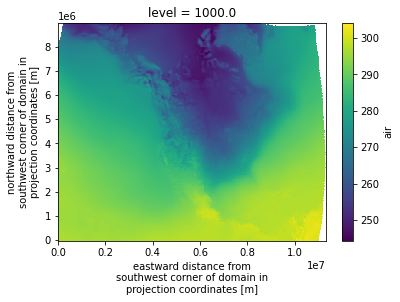

In [10]:
ds_target.air.isel(level=0).mean("time").plot()